In [11]:
from rapidfuzz.distance import Levenshtein
import string

from termios import VKILL
import numpy as np
import random


def norm_edit_dis(pred, target):
    ignore_space = True
    is_filter = False

    def _normalize_text(text):
        text = ''.join(
            filter(lambda x: x in (string.digits + string.ascii_letters), text))
        return text.lower()
        
    if ignore_space:
        pred = pred.replace(" ", "")
        target = target.replace(" ", "")
    if is_filter:
        pred = _normalize_text(pred)
        target = _normalize_text(target)
    # return
    return Levenshtein.normalized_distance(pred, target)


from PIL import Image

def get_shape(path):
    image = Image.open(path)
    w, h = image.size
    if h > w*2:
        return "Vertical"
    elif h*2 < w:
        return "Horizontal"
    else:
        return "Square"

import string


alphabet = list(string.ascii_lowercase)+list(string.ascii_uppercase)
def get_language(text):
    for char in text:
        if char in alphabet:
            return "English"
    return "Korean"

def get_count(data_list):

    # 범위를 나누어 개수를 세기 위한 리스트 생성
    count_list = []

    # 0~100 범위를 5개 구간으로 나누고, 각 구간의 개수를 세서 count_list에 추가
    for i in range(0, 101, 5):
        count = sum(1 for num in data_list if i <= num < i + 5)
        count_list.append(count)

    return np.array(count_list)
    

In [24]:


result_path = "/home/works/rec_PPOCR_sangmu_and_outsourcing_final_v5_1/inference_result"
answer_path = "/home/labelsets/sangmu_test_v1/eval_label.txt"


with open(answer_path) as f:
    answer = [line.rstrip("\n").split("\t") for line in f.readlines()]
    answer = {"datasets/"+k: v for k, v in answer}

with open(result_path) as f:
    target = [line.rstrip("\n").split("\t") for line in f.readlines()]
    target = {k: v for k, v, _ in target}
    # answer = {k: v for k, v in answer}

result = []

for path, pred in target.items():
    label = answer[path]    
    dis = norm_edit_dis(pred, label)
    level = "hard" if dis > 0.6 else "easy"
    lang = get_language(label)
    shape = get_shape("home/"+path)
    result.append([path, pred, label, dis, level, lang, shape])
     
shape_list = ["Vertical", "Square", "Horizontal"]
langage_list = ["English", "Korean"]
distance = {shape: {lang: []for lang in langage_list}for shape in shape_list}


for path, pred, label, dis, level, lang, shape in result:
    distance[shape][lang].append(dis)

for shape in shape_list:
    for lang in langage_list:
        x = distance[shape][lang]
        x = 100 - np.array(np.array(x)*10, dtype=int)*10
        distance[shape][lang] = x


hard = easy = 0
with open("/home/easy.txt", "w") as easy_f:
    with open("/home/hard.txt", "w") as hard_f:
        for path, pred, label, dis, level, lang, shape in result:
            if level == "hard":
                if random.random() < 0.5:
                    hard += 1
                    hard_f.write(f"{path}\t{label}\n")
                else:
                    easy += 1
                    easy_f.write(f"{path}\t{label}\n")
            else:
                easy += 1
                easy_f.write(f"{path}\t{label}\n")

print(easy, hard)


5417 122


0.6008285268604632

In [4]:
num = {shape: {lang: []for lang in langage_list}for shape in shape_list}
for shape in shape_list:
    for lang in langage_list:
        num[shape][lang] = len(distance[shape][lang])
num

{'Vertical': {'English': 80, 'Korean': 329},
 'Square': {'English': 823, 'Korean': 1031},
 'Horizontal': {'English': 1316, 'Korean': 1960}}

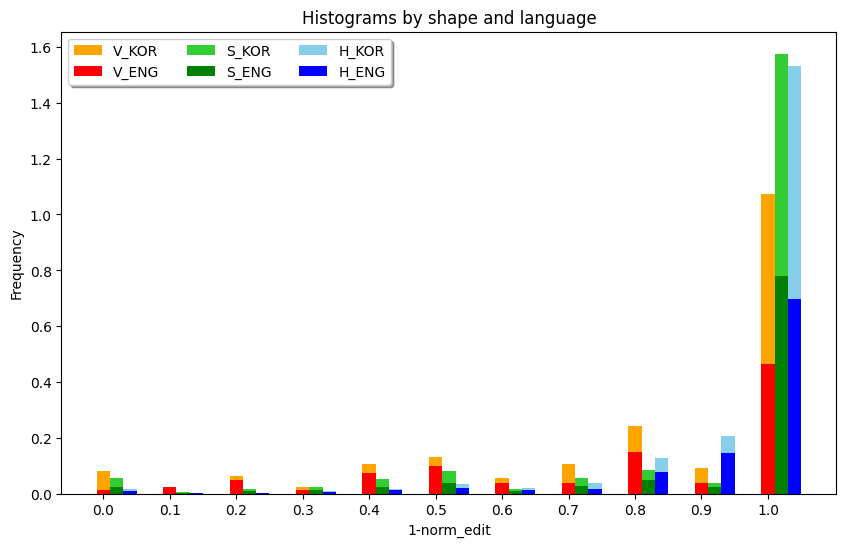

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 각 항목의 데이터 생성
data = {
    "V_KOR": get_count(distance["Vertical"]["Korean"]),
    "V_ENG": get_count(distance["Vertical"]["English"]),
    "S_KOR": get_count(distance["Square"]["Korean"]),
    "S_ENG": get_count(distance["Square"]["English"]),
    "H_KOR": get_count(distance["Horizontal"]["Korean"]),
    "H_ENG": get_count(distance["Horizontal"]["English"])
}

data["V_ENG"] = data["V_ENG"]/num["Vertical"]["English"] 
data["V_KOR"] = data["V_KOR"]/num["Vertical"]["Korean"]
data["S_ENG"] = data["S_ENG"]/num["Square"]["English"]
data["S_KOR"] = data["S_KOR"]/num["Square"]["Korean"]
data["H_ENG"] = data["H_ENG"]/num["Horizontal"]["English"]
data["H_KOR"] = data["H_KOR"]/num["Horizontal"]["Korean"]


data["V_KOR"] += data["V_ENG"]
data["S_KOR"] += data["S_ENG"]
data["H_KOR"] += data["H_ENG"]

# 데이터 그룹화
group1 = ["V_KOR", "S_KOR", "H_KOR"]
color1=['orange', 'limegreen', 'skyblue']

group2 = ["V_ENG", "S_ENG", "H_ENG"]
color2=['red', 'green', 'blue']

# 그래프 그리기
plt.figure(figsize=(10, 6))

bar_width = 2/100




# 첫 번째 그룹 그리기
for i in range(len(group1)):
    key = group1[i]
    plt.bar((np.arange(len(data[key]))*5)/100+bar_width * i, data[key], width=bar_width, label=key, color=color1[i])
    key = group2[i]
    plt.bar((np.arange(len(data[key]))*5)/100 + bar_width * i, data[key], width=bar_width, label=key, color=color2[i])

# 두 번째 그룹 그리기 (첫 번째 그룹 위에 중첩)
# for i, key in enumerate(group2):

# 범례 추가
plt.legend(loc='upper left', fancybox=True, shadow=True, ncol=3)

# 그래프 제목 및 축 레이블 설정
plt.title('Histograms by shape and language')
plt.xlabel('1-norm_edit')
plt.ylabel('Frequency')

# x축 눈금과 레이블 설정
# plt.xticks(range(len(data["V_KOR"])), [f'Category {i+1}' for i in range(len(data["V_KOR"]))])
plt.xticks(np.arange(0, 101, 10)/100)

# 그래프 보이기
plt.show()


In [10]:
(np.arange(len(data[key]))*5 + bar_width * i)/100

array([0.04, 0.09, 0.14, 0.19, 0.24, 0.29, 0.34, 0.39, 0.44, 0.49, 0.54,
       0.59, 0.64, 0.69, 0.74, 0.79, 0.84, 0.89, 0.94, 0.99, 1.04])